# Advantage Actor Critic (A2A) with CartPole

Actor Critic methods are a cross-over between policy-based and value-based methods. Policy-based methods aim to directly learn an optimal policy by maximising an objective function related to the performance of the agent in an environment, whilst value-based methods first try to estimate the future reward of each state-action pair in the environment and indirectly learn an optimal policy through these action-values. Both of these methods have their drawbacks: 

#### Value-based:
    - Works well with a finite action-space, but does not scale to large action-spaces.
    - Often do not converge, as a small change in value-space can cause a large deviation in policy-space.
    
#### Policy-based:
    - Directly optimising in policy-space results in smoother learning, but tends to converge towards local-minima.
    - Suffers from high variance as updates occur on an episodic basis. 
    - Often slow to learn.
    
By combining these approaches, some of the problems that come with the individual approaches can be alleviated. 

In actor-critic methods, there are two separate models. One model, known as the critic, is used to estimate the action-values of the environment. The other model, known as the actor, is used to learn a policy-function with the help of the action-values learned by the critic. Since the policy-updates can occur during the episode, using bootstrapped values obtained by the critic, the overall variance of the agent is reduced. As a result, the actor-critic methods are often faster than policy-based methods alone and have nicer convergence properties than value-based methods. Additionally, actor-critic methods can be used when the action space is continuous and are able to learn stochastic policies.

#### Import necessary modules

In [1]:
import gym
import torch
import numpy as np
import matplotlib.pyplot as plt
from actor_critic import ActorCritic, Agent

#### Set up the CartPole environment and hyperparameters for the agent + networks

In [20]:
# Set up the CartPole Environment.
env = gym.make("CartPole-v0")

# Retrieve the state space and action space objects for CartPole.
state_space = env.observation_space
action_space = env.action_space
p_hidden_size = 64
v_hidden_size = 64

episodes = 200
discount = 0.99

runs = 1

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


#### Run experiments (50 experiments for learning CartPole over 1000 episodes)

In [23]:
run_rewards = []

# For the number of experiments set
for run in range(runs):
    
    # Instantiate the actor-critic model
    model = ActorCritic(state_space, action_space, p_hidden_size, v_hidden_size)
    
    # Instantiate the agent
    agent = Agent(model)

    # Set up the loss function and optimiser for the NNs.
    optimiser = torch.optim.RMSprop(model.parameters())
    
    # Cache the episodic rewards
    episode_rewards = []

    # For each episode in a run.
    for episode in range(episodes):
        # Reset the policy and value history of the agent.
        agent.reset_history()
        
        # Reset the environment and store the initial state
        state = torch.Tensor(env.reset())

        # Store the total reward of an episode
        total_reward = 0
        
        # Set boolean flag to say whether the episode has ended or not.
        done = False
        
        # Whilst the episode has not finished.
        while not done:
            
            # Use the agent's policy to select an action, given a state.
            action = agent.select_move(state)
            
            # Perform the selected action in the environment and receive
            # the next state, reward, and whether the episode is finished.
            next_state, reward, done, info = env.step(action.data.numpy())

            # Cache the reward at time t
            agent.policy_reward.append(reward)

            # Set the current state to the next state.
            state = torch.Tensor(next_state)
            
            # Update the total reward.
            total_reward += reward

        # Cache the total reward of the episodes
        episode_rewards.append(total_reward)
        
        # Cache the discounted rewards at each step of the episode
        rewards = []
        R = 0

        # Calculate the discounted reward at each step of the episode.
        for r in agent.policy_reward[::-1]:
            R = r + discount * R
            rewards.insert(0, R)

        # Normalise the rewards for stability.
        rewards = torch.FloatTensor(rewards).view(-1, 1)
        rewards = (rewards - rewards.mean()) / (rewards.std())

        # Retrieve the log probabilities of the actions over time.
        log_pi_t = agent.policy_history
        
        # Retrieve the values of each state over time.
        v_s_t = agent.value_history
        
        # Calculate the advantage.
        advantage = rewards - v_s_t

        # Calculate the policy loss
        policy_loss = (-log_pi_t * advantage.detach()).mean()

        # Calculate the value loss (MSE)
        value_loss = advantage.pow(2).mean()
        
        entropy_loss = agent.ce_history.mean()
        
        # Combine the two losses together
        loss = policy_loss + value_loss - 0.5 * entropy_loss
        print(entropy_loss)
#        print(policy_loss, value_loss, entropy_loss)

        # Zero the gradients in the optimiser
        optimiser.zero_grad()

        # Retrieve gradients of the loss with respect to the networks' parameters.
        loss.backward(retain_graph=True)

        # Take a gradient descent step.
        optimiser.step()
    
    # Cache the episodic rewards over each run.
    run_rewards.append(episode_rewards)


tensor([[0.6931]], grad_fn=<NegBackward>)
tensor(0.6927, grad_fn=<MeanBackward1>)
tensor(0.6831, grad_fn=<MeanBackward1>)
tensor(0.5321, grad_fn=<MeanBackward1>)
tensor(0.4455, grad_fn=<MeanBackward1>)
tensor(0.3842, grad_fn=<MeanBackward1>)
tensor(0.3466, grad_fn=<MeanBackward1>)
tensor(0.3310, grad_fn=<MeanBackward1>)
tensor(0.3551, grad_fn=<MeanBackward1>)
tensor(0.4007, grad_fn=<MeanBackward1>)
tensor(0.4224, grad_fn=<MeanBackward1>)
tensor(0.4420, grad_fn=<MeanBackward1>)
tensor(0.4761, grad_fn=<MeanBackward1>)
tensor(0.4843, grad_fn=<MeanBackward1>)
tensor(0.4993, grad_fn=<MeanBackward1>)
tensor(0.5096, grad_fn=<MeanBackward1>)
tensor(0.5235, grad_fn=<MeanBackward1>)
tensor(0.5280, grad_fn=<MeanBackward1>)
tensor(0.5336, grad_fn=<MeanBackward1>)
tensor(0.5431, grad_fn=<MeanBackward1>)
tensor(0.5467, grad_fn=<MeanBackward1>)
tensor(0.5516, grad_fn=<MeanBackward1>)
tensor(0.5553, grad_fn=<MeanBackward1>)
tensor(0.5568, grad_fn=<MeanBackward1>)
tensor(0.5616, grad_fn=<MeanBackward1>

#### Plot the moving average of the agent over a number of episodes

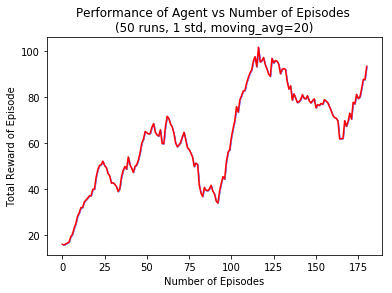

In [24]:
%matplotlib inline
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

means = np.mean([moving_average(rewards) for rewards in run_rewards], axis=0)
stds = np.std([moving_average(rewards) for rewards in run_rewards], axis=0)

plt.plot(range(len(means)), means, color='red')

plt.fill_between(range(len(means)), means, means + stds, color='blue', alpha=.25)
plt.fill_between(range(len(means)), means, means - stds, color='blue', alpha=.25)

plt.title('Performance of Agent vs Number of Episodes \n(50 runs, 1 std, moving_avg=20)')
plt.xlabel('Number of Episodes')
plt.ylabel('Total Reward of Episode')

plt.show()

In [11]:
# Set up the CartPole Environment.
env = gym.make("CartPole-v0")

# Retrieve the state space and action space objects for CartPole.
state_space = env.observation_space
action_space = env.action_space
p_hidden_size = 64
v_hidden_size = 64

episodes = 200
discount = 0.99

runs = 5

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [12]:
run_rewards = []

# For the number of experiments set
for run in range(runs):
    
    # Instantiate the actor-critic model
    model = ActorCritic(state_space, action_space, p_hidden_size, v_hidden_size)
    
    # Instantiate the agent
    agent = Agent(model)

    # Set up the loss function and optimiser for the NNs.
    optimiser = torch.optim.RMSprop(model.parameters())
    
    # Cache the episodic rewards
    episode_rewards = []

    # For each episode in a run.
    for episode in range(episodes):
        # Reset the policy and value history of the agent.
        agent.reset_history()
        
        # Reset the environment and store the initial state
        state = torch.Tensor(env.reset())

        # Store the total reward of an episode
        total_reward = 0
        
        # Set boolean flag to say whether the episode has ended or not.
        done = False
        
        # Whilst the episode has not finished.
        while not done:
            
            # Use the agent's policy to select an action, given a state.
            action = agent.select_move(state)
            
            # Perform the selected action in the environment and receive
            # the next state, reward, and whether the episode is finished.
            next_state, reward, done, info = env.step(action.data.numpy())

            # Cache the reward at time t
            agent.policy_reward.append(reward)

            # Set the current state to the next state.
            state = torch.Tensor(next_state)
            
            # Update the total reward.
            total_reward += reward

        # Cache the total reward of the episodes
        episode_rewards.append(total_reward)
        
        # Cache the discounted rewards at each step of the episode
        rewards = []
        R = 0

        # Calculate the discounted reward at each step of the episode.
        for r in agent.policy_reward[::-1]:
            R = r + discount * R
            rewards.insert(0, R)

        # Normalise the rewards for stability.
        rewards = torch.FloatTensor(rewards).view(-1, 1)
        rewards = (rewards - rewards.mean()) / (rewards.std())

        # Retrieve the log probabilities of the actions over time.
        log_pi_t = agent.policy_history
        
        # Retrieve the values of each state over time.
        v_s_t = agent.value_history
        
        # Calculate the advantage.
        advantage = rewards - v_s_t

        # Calculate the policy loss
        policy_loss = (-log_pi_t * advantage.detach()).mean()

        # Calculate the value loss (MSE)
        value_loss = advantage.pow(2).mean()
        
        entropy_loss = agent.ce_history.mean().detach()
        
        # Combine the two losses together
        loss = policy_loss + value_loss
        print(entropy_loss)
#        print(policy_loss, value_loss, entropy_loss)

        # Zero the gradients in the optimiser
        optimiser.zero_grad()

        # Retrieve gradients of the loss with respect to the networks' parameters.
        loss.backward()

        # Take a gradient descent step.
        optimiser.step()
    
    # Cache the episodic rewards over each run.
    run_rewards.append(episode_rewards)


tensor([[0.6834]], grad_fn=<NegBackward>)
tensor(0.6557)
tensor(0.3679)
tensor(0.2712)
tensor(0.2154)
tensor(0.1835)
tensor(0.1607)
tensor(0.1419)
tensor(0.1294)
tensor(0.1177)
tensor(0.1087)
tensor(0.1021)
tensor(0.0973)
tensor(0.0924)
tensor(0.0878)
tensor(0.0851)
tensor(0.0816)
tensor(0.0793)
tensor(0.0769)
tensor(0.0751)
tensor(0.0729)
tensor(0.0709)
tensor(0.0694)
tensor(0.0672)
tensor(0.0657)
tensor(0.0645)
tensor(0.0632)
tensor(0.0621)
tensor(0.0609)
tensor(0.0598)
tensor(0.0586)
tensor(0.0576)
tensor(0.0566)
tensor(0.0557)
tensor(0.0550)
tensor(0.0551)
tensor(0.0555)
tensor(0.0555)
tensor(0.0555)
tensor(0.0555)
tensor(0.0555)
tensor(0.0555)
tensor(0.0553)
tensor(0.0553)
tensor(0.0558)
tensor(0.0564)
tensor(0.0565)
tensor(0.0568)
tensor(0.0582)
tensor(0.0592)
tensor(0.0612)
tensor(0.0624)
tensor(0.0633)
tensor(0.0639)
tensor(0.0667)
tensor(0.0674)
tensor(0.0676)
tensor(0.0678)
tensor(0.0680)
tensor(0.0681)
tensor(0.0680)
tensor(0.0682)
tensor(0.0683)
tensor(0.0696)
tensor(0.0699

tensor(0.4692)
tensor(0.4695)
tensor(0.4693)
tensor(0.4699)
tensor(0.4704)
tensor(0.4705)
tensor(0.4709)
tensor(0.4712)
tensor(0.4714)
tensor(0.4713)
tensor(0.4712)
tensor(0.4711)
tensor(0.4710)
tensor(0.4705)
tensor(0.4702)
tensor(0.4701)
tensor(0.4702)
tensor(0.4701)
tensor(0.4701)
tensor(0.4701)
tensor(0.4700)
tensor(0.4699)
tensor(0.4699)
tensor(0.4698)
tensor(0.4696)
tensor(0.4697)
tensor(0.4695)
tensor(0.4693)
tensor(0.4690)
tensor(0.4689)
tensor(0.4688)
tensor(0.4684)
tensor(0.4681)
tensor(0.4680)
tensor(0.4680)
tensor(0.4679)
tensor(0.4678)
tensor(0.4677)
tensor(0.4676)
tensor(0.4674)
tensor(0.4672)
tensor(0.4671)
tensor(0.4668)
tensor(0.4667)
tensor(0.4662)
tensor(0.4658)
tensor(0.4655)
tensor(0.4652)
tensor(0.4648)
tensor(0.4643)
tensor(0.4640)
tensor(0.4637)
tensor(0.4632)
tensor(0.4629)
tensor(0.4627)
tensor(0.4623)
tensor(0.4621)
tensor(0.4620)
tensor(0.4618)
tensor(0.4616)
tensor(0.4615)
tensor(0.4611)
tensor([[0.6904]], grad_fn=<NegBackward>)
tensor(0.6845)
tensor(0.6333

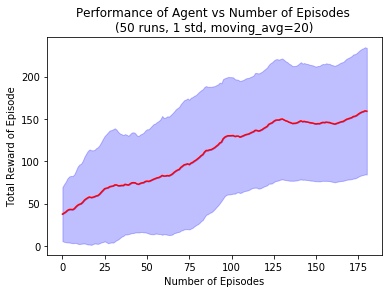

In [13]:
%matplotlib inline
def moving_average(a, n=20) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

means = np.mean([moving_average(rewards) for rewards in run_rewards], axis=0)
stds = np.std([moving_average(rewards) for rewards in run_rewards], axis=0)

plt.plot(range(len(means)), means, color='red')

plt.fill_between(range(len(means)), means, means + stds, color='blue', alpha=.25)
plt.fill_between(range(len(means)), means, means - stds, color='blue', alpha=.25)

plt.title('Performance of Agent vs Number of Episodes \n(50 runs, 1 std, moving_avg=20)')
plt.xlabel('Number of Episodes')
plt.ylabel('Total Reward of Episode')

plt.show()